In [3]:
pip install snowflake-snowpark-python pandas scikit-learn streamlit requests

Note: you may need to restart the kernel to use updated packages.


In [4]:
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import StructType, StructField, StringType, DateType, FloatType
from meteostat import Stations, Daily
from datetime import datetime
import pandas as pd

# Snowflake connection details
connection_parameters = {
   
}
session = Session.builder.configs(connection_parameters).create()


In [5]:
# SQL command to create the storage integration
create_integration_sql = """
CREATE OR REPLACE STORAGE INTEGRATION s3_integration
TYPE = EXTERNAL_STAGE
STORAGE_PROVIDER = 'S3'
STORAGE_AWS_ROLE_ARN =''
STORAGE_ALLOWED_LOCATIONS = ('')
ENABLED = TRUE;
"""

# Execute the SQL command
session.sql(create_integration_sql).collect()

print("Storage integration created successfully.")


Storage integration created successfully.


In [ ]:
# Import python packages
import streamlit as st
import pandas as pd

# We can also use Snowpark for our analyses!
from snowflake.snowpark.context import get_active_session
session = get_active_session()

In [6]:
import pandas as pd
import os
from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import col
import snowflake.connector

# S3 bucket details
s3_bucket_name = "flightdatabucket02"
s3_path = "flights.csv"
s3_stage_name = "FLIGHT_S3_STAGE"

# Create the stage using the existing storage integration
session.sql(f"""
    CREATE OR REPLACE STAGE {s3_stage_name}
    URL = 's3://{s3_bucket_name}/'
    STORAGE_INTEGRATION = s3_integration
    FILE_FORMAT = (TYPE = 'CSV', FIELD_OPTIONALLY_ENCLOSED_BY = '"', SKIP_HEADER = 1);
""").collect()

print(f"Stage {s3_stage_name} created successfully.")

# Define the target table schema
table_name = "FLIGHT_DATA"

session.sql(f"""
    CREATE OR REPLACE TABLE {table_name} (
        YEAR INT,
        MONTH INT,
        DAY INT,
        DAY_OF_WEEK INT,
        AIRLINE STRING,
        FLIGHT_NUMBER INT,
        TAIL_NUMBER STRING,
        ORIGIN_AIRPORT STRING,
        DESTINATION_AIRPORT STRING,
        SCHEDULED_DEPARTURE INT,
        DEPARTURE_TIME FLOAT,
        DEPARTURE_DELAY FLOAT,
        TAXI_OUT FLOAT,
        WHEELS_OFF FLOAT,
        SCHEDULED_TIME FLOAT,
        ELAPSED_TIME FLOAT,
        AIR_TIME FLOAT,
        DISTANCE INT,
        WHEELS_ON FLOAT,
        TAXI_IN FLOAT,
        SCHEDULED_ARRIVAL INT,
        ARRIVAL_TIME FLOAT,
        ARRIVAL_DELAY FLOAT,
        DIVERTED INT,
        CANCELLED INT,
        CANCELLATION_REASON STRING,
        AIR_SYSTEM_DELAY FLOAT,
        SECURITY_DELAY FLOAT,
        AIRLINE_DELAY FLOAT,
        LATE_AIRCRAFT_DELAY FLOAT,
        WEATHER_DELAY FLOAT
    );
""").collect()

print(f"Table {table_name} created successfully.")

# Load data from the S3 stage into the Snowflake table
session.sql(f"""
    COPY INTO {table_name}
    FROM @{s3_stage_name}/{s3_path}
    FILE_FORMAT = (TYPE = 'CSV', FIELD_OPTIONALLY_ENCLOSED_BY = '"', SKIP_HEADER = 1);
""").collect()

print(f"Data successfully loaded into {table_name}.")

# Verify the data load
result = session.sql(f"SELECT COUNT(*) AS RECORD_COUNT FROM {table_name};").collect()
print(f"Total records loaded: {result[0]['RECORD_COUNT']}")

# Optional: Drop the stage after loading the data
session.sql(f"DROP STAGE {s3_stage_name};").collect()
print(f"Stage {s3_stage_name} dropped successfully.")



Stage FLIGHT_S3_STAGE created successfully.
Table FLIGHT_DATA created successfully.
Data successfully loaded into FLIGHT_DATA.
Total records loaded: 5819079
Stage FLIGHT_S3_STAGE dropped successfully.


In [ ]:

# Close the session
session.close()

In [ ]:
import snowflake.connector
import os

# Snowflake connection details
conn = snowflake.connector.connect(
    user='nvijayakumar',
    password='Hanuman!93',
    account='zmb70645.us-east-1',
    warehouse='COMPUTE_WH',
    database='AIRLINEDELAY',
    schema='PUBLIC'
)

# File paths
airports_file = ''
airlines_file = ''

# Create Snowflake cursor
cursor = conn.cursor()

# Create Snowflake tables
cursor.execute("""
    CREATE OR REPLACE TABLE AIRPORT (
        IATA_CODE STRING,
        AIRPORT STRING,
        CITY STRING,
        STATE STRING,
        COUNTRY STRING,
        LATITUDE FLOAT,
        LONGITUDE FLOAT
    );
""")
cursor.execute("""
    CREATE OR REPLACE TABLE AIRLINES (
        IATA_CODE STRING,
        AIRLINE STRING
    );
""")
print("Tables created successfully.")

# Create a stage for file upload
stage_name = "LOCAL_STAGE"
cursor.execute(f"""
    CREATE OR REPLACE STAGE {stage_name}
    FILE_FORMAT = (TYPE = 'CSV' FIELD_OPTIONALLY_ENCLOSED_BY = '"' SKIP_HEADER = 1);
""")
print(f"Stage {stage_name} created successfully.")

# Upload CSV files to the stage
cursor.execute(f"PUT 'file://{os.path.abspath(airports_file)}' @{stage_name}")
cursor.execute(f"PUT 'file://{os.path.abspath(airlines_file)}' @{stage_name}")
print("Files uploaded to stage.")

# Load data from the stage into Snowflake tables
cursor.execute(f"""
    COPY INTO AIRPORT
    FROM @{stage_name}/airports.csv
    FILE_FORMAT = (TYPE = 'CSV')
    ON_ERROR = 'CONTINUE';
""")
cursor.execute(f"""
    COPY INTO AIRLINES
    FROM @{stage_name}/airlines.csv
    FILE_FORMAT = (TYPE = 'CSV');
""")
print("Data successfully loaded into Snowflake tables.")

# Optional: Drop the stage
cursor.execute(f"DROP STAGE {stage_name}")
print(f"Stage {stage_name} dropped successfully.")




Tables created successfully.
Stage LOCAL_STAGE created successfully.
Files uploaded to stage.


In [ ]:
# Close the connection
cursor.close()
conn.close()

In [ ]:
query = "SELECT * FROM FLIGHT_DATA"
flightsinfo = session.sql(query).to_pandas()

# Use pandas' describe method for descriptive statistics
summary = flightsinfo.describe()

# Display the summary statistics
print(summary)

In [13]:
query = "SELECT * FROM AIRPORT"
airport = session.sql(query).to_pandas()

# Use pandas' describe method for descriptive statistics
summary = airport.head()

# Display the summary statistics
print(summary)

  IATA_CODE                              AIRPORT         CITY STATE COUNTRY  \
0       ABE  Lehigh Valley International Airport    Allentown    PA     USA   
1       ABI             Abilene Regional Airport      Abilene    TX     USA   
2       ABQ    Albuquerque International Sunport  Albuquerque    NM     USA   
3       ABR            Aberdeen Regional Airport     Aberdeen    SD     USA   
4       ABY   Southwest Georgia Regional Airport       Albany    GA     USA   

   LATITUDE  LONGITUDE  
0  40.65236  -75.44040  
1  32.41132  -99.68190  
2  35.04022 -106.60919  
3  45.44906  -98.42183  
4  31.53552  -84.19447  


In [ ]:
query = "SELECT * FROM AIRLINES"
airline = session.sql(query).to_pandas()

# Use pandas' describe method for descriptive statistics
summary = airline.head()

# Display the summary statistics
print(summary)

In [16]:
airport.shape#printing actual shape of airport data

(322, 7)

In [17]:
airport.info()#printing column names and datatype of each column of airport

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [19]:
airline.head(10)# printing top 10 rows of airlines

,IATA_CODE,AIRLINE
0,IATA_CODE,AIRLINE
1,UA,United Air Lines Inc.
2,AA,American Airlines Inc.
3,US,US Airways Inc.
4,F9,Frontier Airlines Inc.
5,B6,JetBlue Airways
6,OO,Skywest Airlines Inc.
7,AS,Alaska Airlines Inc.
8,NK,Spirit Air Lines
9,WN,Southwest Airlines Co.


In [ ]:
airport.isna().sum()

In [ ]:
airport=airport.dropna()

  Obtaining dependency information for folium from https://files.pythonhosted.org/packages/03/12/45a714482b9aa23cf708c5d07810d8133c4277b9d28db55e51352a0cb2da/folium-0.18.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for branca>=0.6.0 from https://files.pythonhosted.org/packages/fc/be/720f85abacd654ec86f1431bc7c004eae74417bd9d0e7a2bc43601062627/branca-0.8.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 4.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [31]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd

# Filter flights where arrival delay is more than 20 minutes
delayed_flights = flightsinfo[flightsinfo['ARRIVAL_DELAY'] > 20]

# Count the number of such flights per destination airport
delaycount = delayed_flights['DESTINATION_AIRPORT'].value_counts().reset_index()
delaycount.columns = ['DESTINATION_AIRPORT', 'DELAY_COUNT']

# Merge delay count with airport data
airport = pd.merge(
    airport[['IATA_CODE', 'LATITUDE', 'LONGITUDE', 'CITY', 'AIRPORT']],
    delaycount,
    left_on='IATA_CODE',
    right_on='DESTINATION_AIRPORT'
)

# Ensure proper columns and rename
airport = airport[['IATA_CODE', 'LATITUDE', 'LONGITUDE', 'CITY', 'AIRPORT', 'DELAY_COUNT']]

# Define size ranges and corresponding colors
size_ranges = [100, 1000, 10000, 100000]
colors = ['green', 'yellow', 'orange', 'red']
labels = ["1 to 100", "100 to 1000", "1000 to 10000", "10000 to 100000"]

# Function to determine marker size based on delay count
def get_marker_size(flight_count):
    for i, val in enumerate(size_ranges):
        if flight_count < val:
            return i
    return len(size_ranges) - 1

# Step 2: Create the Map
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)  # Center map on USA

# Add MarkerCluster to manage overlapping markers
marker_cluster = MarkerCluster().add_to(m)

# Add markers to the map
for _, row in airport.iterrows():
    size_index = get_marker_size(row['DELAY_COUNT'])
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=(size_index + 1) * 3,  # Adjust marker size
        color=colors[size_index],
        fill=True,
        fill_color=colors[size_index],
        fill_opacity=0.6,
        popup=f"{row['AIRPORT']} ({row['IATA_CODE']}): {row['DELAY_COUNT']} delays"
    ).add_to(marker_cluster)

# Add legend
legend_html = '''
<div style="
    position: fixed; 
    bottom: 10px; 
    left: 10px; 
    width: 200px; 
    height: auto; 
    background-color: white; 
    border:2px solid grey; 
    z-index:9999; 
    font-size:12px; 
    font-weight:bold; 
    padding: 10px; 
    box-shadow: 0 2px 6px rgba(0,0,0,0.3);">
<b>Arrival Delays Over 20 Minutes Per Year</b><br>
<i style="background: green; width: 20px; height: 20px; display: inline-block; margin-right: 5px;"></i> 1 to 100<br>
<i style="background: yellow; width: 20px; height: 20px; display: inline-block; margin-right: 5px;"></i> 100 to 1000<br>
<i style="background: orange; width: 20px; height: 20px; display: inline-block; margin-right: 5px;"></i> 1000 to 10000<br>
<i style="background: red; width: 20px; height: 20px; display: inline-block; margin-right: 5px;"></i> 10000 to 100000<br>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
m.save('airports_with_delays.html')


In [32]:
from IPython.display import IFrame
# Display the saved HTML map in Jupyter
IFrame('airports_with_delays.html', width=700, height=500)

In [35]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd

# Step 1: Prepare the Data
# Count the number of flights per origin airport
flightcount = flightsinfo['ORIGIN_AIRPORT'].value_counts().reset_index()
flightcount.columns = ['ORIGIN_AIRPORT', 'FLIGHT_COUNT']

# Merge flight count with airport data
airport = pd.merge(
    airport[['IATA_CODE', 'LATITUDE', 'LONGITUDE', 'CITY', 'AIRPORT']],
    flightcount,
    left_on='IATA_CODE',
    right_on='ORIGIN_AIRPORT'
)

# Ensure proper columns and rename
airport = airport[['IATA_CODE', 'LATITUDE', 'LONGITUDE', 'CITY', 'AIRPORT', 'FLIGHT_COUNT']]

# Define size ranges and corresponding colors
size_ranges = [100, 1000, 10000, 100000, 1000000]
colors = ['green', 'orange', 'yellow', 'red', 'lightblue']
labels = ["1 to 100", "100 to 1000", "1000 to 10000", "10000 to 100000", "100000 to 1000000"]

# Function to determine marker size based on flight count
def get_marker_size(flight_count):
    for i, val in enumerate(size_ranges):
        if flight_count < val:
            return i
    return len(size_ranges) - 1

# Step 2: Create the Map
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)  # Center map on USA

# Add MarkerCluster to manage overlapping markers
marker_cluster = MarkerCluster().add_to(m)

# Step 3: Add Markers
for _, row in airport.iterrows():
    size_index = get_marker_size(row['FLIGHT_COUNT'])
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=(size_index + 1) * 2,  # Adjust size of the marker
        color=colors[size_index],
        fill=True,
        fill_color=colors[size_index],
        fill_opacity=0.6,
        popup=f"{row['AIRPORT']} ({row['IATA_CODE']}): {row['FLIGHT_COUNT']} flights"
    ).add_to(marker_cluster)

# Step 4: Add Legend
legend_html = '''
<div style="position: fixed; bottom: 10px; left: 10px; width: 250px; height: auto;
background-color: white; border:2px solid grey; z-index:9999; font-size:12px;
font-weight:bold; padding: 10px; box-shadow: 0 2px 6px rgba(0,0,0,0.3);">
<b>Flights per year</b><br>
<i style="background: green; width: 20px; height: 20px; display: inline-block;
margin-right: 5px;"></i> 1 to 100<br>
<i style="background: orange; width: 20px; height: 20px; display: inline-block;
margin-right: 5px;"></i> 100 to 1000<br>
<i style="background: yellow; width: 20px; height: 20px; display: inline-block;
margin-right: 5px;"></i> 1000 to 10000<br>
<i style="background: red; width: 20px; height: 20px; display: inline-block;
margin-right: 5px;"></i> 10000 to 100000<br>
<i style="background: lightblue; width: 20px; height: 20px; display: inline-block;
margin-right: 5px;"></i> 100000 to 1000000<br>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))
# Save to an HTML file
m.save('flight_counts_map.html')

In [ ]:
from IPython.display import IFrame

# Embed the HTML file in the notebook
IFrame('flight_counts_map.html', width=700, height=500)


In [ ]:
from IPython.display import IFrame
IFrame('http://stackoverflow.org' ,width=700 ,height=350)

In [37]:
flightsinfo_NULL = flightsinfo.isnull().sum()*100/flightsinfo.shape[0]

In [38]:
flightsinfo_NULL

YEAR                    0.000000
MONTH                   0.000000
DAY                     0.000000
DAY_OF_WEEK             0.000000
AIRLINE                 0.000000
FLIGHT_NUMBER           0.000000
TAIL_NUMBER             0.252978
ORIGIN_AIRPORT          0.000000
DESTINATION_AIRPORT     0.000000
SCHEDULED_DEPARTURE     0.000000
DEPARTURE_TIME          1.480526
DEPARTURE_DELAY         1.480526
TAXI_OUT                1.530259
WHEELS_OFF              1.530259
SCHEDULED_TIME          0.000103
ELAPSED_TIME            1.805629
AIR_TIME                1.805629
DISTANCE                0.000000
WHEELS_ON               1.589822
TAXI_IN                 1.589822
SCHEDULED_ARRIVAL       0.000000
ARRIVAL_TIME            1.589822
ARRIVAL_DELAY           1.805629
DIVERTED                0.000000
CANCELLED               0.000000
CANCELLATION_REASON    98.455357
AIR_SYSTEM_DELAY       81.724960
SECURITY_DELAY         81.724960
AIRLINE_DELAY          81.724960
LATE_AIRCRAFT_DELAY    81.724960
WEATHER_DE

In [40]:
# dropping all rows that contain NaN or missing value of selected columns
flightsinfo1 = flightsinfo.dropna(subset = ["TAIL_NUMBER",'DEPARTURE_TIME','DEPARTURE_DELAY','TAXI_OUT','WHEELS_OFF','ELAPSED_TIME','AIR_TIME','WHEELS_ON','TAXI_IN','ARRIVAL_TIME','ARRIVAL_DELAY'])

In [41]:
flightsinfo1.isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER                  0
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME               0
DEPARTURE_DELAY              0
TAXI_OUT                     0
WHEELS_OFF                   0
SCHEDULED_TIME               0
ELAPSED_TIME                 0
AIR_TIME                     0
DISTANCE                     0
WHEELS_ON                    0
TAXI_IN                      0
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME                 0
ARRIVAL_DELAY                0
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5714008
AIR_SYSTEM_DELAY       4650569
SECURITY_DELAY         4650569
AIRLINE_DELAY          4650569
LATE_AIRCRAFT_DELAY    4650569
WEATHER_DELAY          4650569
dtype: int64

In [42]:
#Dropping all the non-contributing factors of delays as they are redundant ,we are only going to focus on the over al
flightsinfo2 = flightsinfo1.drop(['CANCELLATION_REASON','AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY',
'LATE_AIRCRAFT_DELAY','WEATHER_DELAY'],axis = 1)

In [43]:
flightsinfo2.isnull().sum()

YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
AIRLINE                0
FLIGHT_NUMBER          0
TAIL_NUMBER            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
TAXI_OUT               0
WHEELS_OFF             0
SCHEDULED_TIME         0
ELAPSED_TIME           0
AIR_TIME               0
DISTANCE               0
WHEELS_ON              0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
DIVERTED               0
CANCELLED              0
dtype: int64

In [44]:
flightsinfo2.shape

(5714008, 25)

In [45]:
flightsinfo2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5714008 entries, 0 to 5819078
Data columns (total 25 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       string 
 8   DESTINATION_AIRPORT  string 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24  CAN

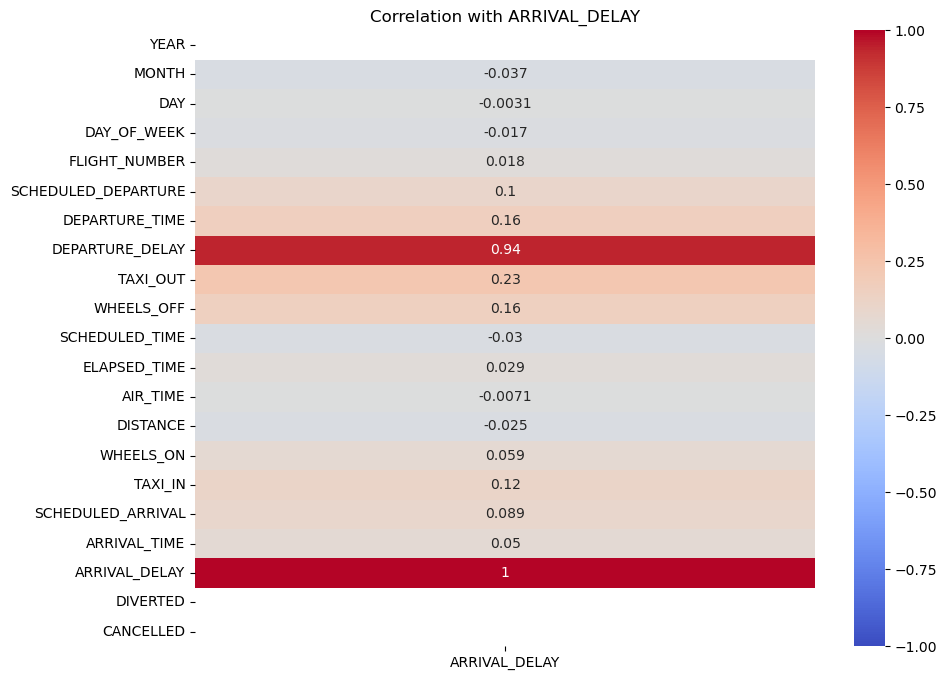

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure all columns are numeric
flightsinfo2_numeric = flightsinfo2.select_dtypes(include=['number'])

# Check if 'ARRIVAL_DELAY' exists and is numeric
if 'ARRIVAL_DELAY' in flightsinfo2.columns:
    flightsinfo2['ARRIVAL_DELAY'] = pd.to_numeric(flightsinfo2['ARRIVAL_DELAY'], errors='coerce')

# Recompute the correlation matrix
correlation_matrix = flightsinfo2_numeric.corr()

# Filter for correlations with ARRIVAL_DELAY
if 'ARRIVAL_DELAY' in correlation_matrix.columns:
    arrival_delay_corr = correlation_matrix[['ARRIVAL_DELAY']]

    # Plot the correlation heatmap
    plt.figure(figsize=(3,3))
    sns.heatmap(arrival_delay_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation with ARRIVAL_DELAY')
    
    # Save the plot as an image
    plt.savefig("correlation_heatmap.png")
    
    # Display the saved image
    from IPython.display import Image, display
    display(Image(filename="correlation_heatmap.png"))


In [48]:
flightsinfo2[['WHEELS_OFF','DEPARTURE_TIME','SCHEDULED_DEPARTURE']]

,WHEELS_OFF,DEPARTURE_TIME,SCHEDULED_DEPARTURE
0,15.0,2354.0,5
1,14.0,2.0,10
2,34.0,18.0,20
3,30.0,15.0,20
4,35.0,24.0,25
...,...,...,...
5819074,17.0,2355.0,2359
5819075,12.0,2355.0,2359
5819076,7.0,2350.0,2359
5819077,3.0,2353.0,2359


In [51]:
# This function converts a given number
# of hours into a datetime.time object representing the corresponding time in hours and minutes.
# for example-->hours = 1230
# Output: 12:30:00
import datetime
def create_time_formatted(value):
# Convert float to integer by truncating the decimal part
    if isinstance(value, float):
        value = int(value)
    # Check if the value is an integer
    if isinstance(value, int):
    # Handle the special case for 2400
        if value == 2400:
            return datetime.time(0, 0)
    # Format the number as a 4-digit string (e.g., 900 becomes "0900")
        formatted_hours = "{0:04d}".format(value)
    # Extract the first two characters as hours and the last two as minutes
        hour_part = int(formatted_hours[:2])
        minute_part = int(formatted_hours[2:])
    # Return a time object using the extracted hours and minutes
        return datetime.time(hour_part, minute_part)

In [52]:
flightsinfo2['WHEELS_OFF'] = flightsinfo2['WHEELS_OFF'].apply(create_time_formatted)
flightsinfo2['Actual_Departure'] = flightsinfo1['DEPARTURE_TIME'].apply(create_time_formatted)
flightsinfo2['Scheduled_Departure'] = flightsinfo1['SCHEDULED_DEPARTURE'].apply(create_time_formatted)

In [53]:
flightsinfo2[['Actual_Departure','Scheduled_Departure','WHEELS_OFF']]

,Actual_Departure,Scheduled_Departure,WHEELS_OFF
0,23:54:00,00:05:00,00:15:00
1,00:02:00,00:10:00,00:14:00
2,00:18:00,00:20:00,00:34:00
3,00:15:00,00:20:00,00:30:00
4,00:24:00,00:25:00,00:35:00
...,...,...,...
5819074,23:55:00,23:59:00,00:17:00
5819075,23:55:00,23:59:00,00:12:00
5819076,23:50:00,23:59:00,00:07:00
5819077,23:53:00,23:59:00,00:03:00


In [54]:
flightsinfo2['Scheduled_Arrival'] = flightsinfo1['SCHEDULED_ARRIVAL'].apply(create_time_formatted)
flightsinfo2['Actual_Arrival'] = flightsinfo2['ARRIVAL_TIME'].apply(create_time_formatted)

In [55]:
flightsinfo2[['Scheduled_Arrival','Actual_Arrival']]

,Scheduled_Arrival,Actual_Arrival
0,04:30:00,04:08:00
1,07:50:00,07:41:00
2,08:06:00,08:11:00
3,08:05:00,07:56:00
4,03:20:00,02:59:00
...,...,...
5819074,08:19:00,07:53:00
5819075,04:46:00,04:30:00
5819076,04:40:00,04:32:00
5819077,03:40:00,03:30:00


In [57]:
# Function to convert HH:MM:SS to minutes
from datetime import datetime
def time_to_minutes(time_obj):
    return time_obj.hour * 60 + time_obj.minute

In [58]:
flightsinfo2['SCHEDULED_DEPARTURE'] = flightsinfo2['Scheduled_Departure'].apply(time_to_minutes)
flightsinfo2['DEPARTURE_TIME'] = flightsinfo2['Actual_Departure'].apply(time_to_minutes)
flightsinfo2['WHEELS_OFF'] = flightsinfo2['WHEELS_OFF'].apply(time_to_minutes)

In [59]:
flightsinfo2[['SCHEDULED_DEPARTURE','DEPARTURE_TIME','WHEELS_OFF']]

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,WHEELS_OFF
0,5,1434,15
1,10,2,14
2,20,18,34
3,20,15,30
4,25,24,35
...,...,...,...
5819074,1439,1435,17
5819075,1439,1435,12
5819076,1439,1430,7
5819077,1439,1433,3


In [60]:
flightsinfo2.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'Actual_Departure',
       'Scheduled_Departure', 'Scheduled_Arrival', 'Actual_Arrival'],
      dtype='object')

In [61]:
flightsinfo2['DATE'] = pd.to_datetime(flightsinfo2[['YEAR','MONTH','DAY']])

In [64]:
flightsinfo2['DATE']

0         2023-01-01
1         2023-01-01
2         2023-01-01
3         2023-01-01
4         2023-01-01
             ...    
5819074   2023-12-31
5819075   2023-12-31
5819076   2023-12-31
5819077   2023-12-31
5819078   2023-12-31
Name: DATE, Length: 5714008, dtype: datetime64[ns]

In [65]:
# Add a new column 'WEEK' which contains the day of the week from the 'DATE' column
flightsinfo2['WEEK'] = flightsinfo2['DATE'].dt.day_name()

In [66]:
flightsinfo2['WEEK']

0          Sunday
1          Sunday
2          Sunday
3          Sunday
4          Sunday
            ...  
5819074    Sunday
5819075    Sunday
5819076    Sunday
5819077    Sunday
5819078    Sunday
Name: WEEK, Length: 5714008, dtype: object

In [67]:
#Create a TIME_OF_DAY column for further use in visualization purpose
# Function to categorize time of day
def categorize_time_of_day(minutes):
    if 240 <= minutes < 720:
        return 'Morning'
    elif 720 <= minutes < 1080:
        return 'Afternoon'
    elif 1080 <= minutes < 1260:
        return 'Evening'
    else:
        return 'Night'
# Apply the categorization function to create 'Time_of_Day'
flightsinfo2['TIME_OF_DAY'] = flightsinfo2['DEPARTURE_TIME'].apply(categorize_time_of_day)

In [68]:
flightsinfo2['TIME_OF_DAY'].value_counts()

TIME_OF_DAY
Morning      2313775
Afternoon    2057602
Evening       914265
Night         428366
Name: count, dtype: int64

In [70]:
flightsinfo2 = flightsinfo2.merge(airline, left_on='AIRLINE', right_on='IATA_CODE', how='inner')

In [71]:
flightsinfo2.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE_x', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'Actual_Departure',
       'Scheduled_Departure', 'Scheduled_Arrival', 'Actual_Arrival', 'DATE',
       'WEEK', 'TIME_OF_DAY', 'IATA_CODE', 'AIRLINE_y'],
      dtype='object')

In [72]:
flightsinfo2 = flightsinfo2.drop(['IATA_CODE'], axis=1)

In [73]:
flightsinfo2 = flightsinfo2.rename(columns={"AIRLINE_x":"AIRLINE","AIRLINE_y":"AIRLINE_NAME"})

In [74]:
flightsinfo2 = flightsinfo2.merge(airport, left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how='inner')
#The code merges the flightsinfo2 DataFrame with the airport DataFrame based on the 'ORIGIN_AIRPORT' and 'IATA_CODE'# keeping only rows that have matching values in both DataFrames

In [75]:
flightsinfo2.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'Actual_Departure',
       'Scheduled_Departure', 'Scheduled_Arrival', 'Actual_Arrival', 'DATE',
       'WEEK', 'TIME_OF_DAY', 'AIRLINE_NAME', 'IATA_CODE', 'LATITUDE',
       'LONGITUDE', 'CITY', 'AIRPORT', 'FLIGHT_COUNT'],
      dtype='object')

In [76]:
flightsinfo2 = flightsinfo2.merge(airport, left_on='DESTINATION_AIRPORT', right_on='IATA_CODE', how='inner')
#The code merges the flightsinfo2 DataFrame with the airport DataFrame based on the 'DESTINATION_AIRPORT' and 'IATA_C# keeping only rows that have matching values in both DataFrames

In [77]:
flightsinfo2.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'Actual_Departure',
       'Scheduled_Departure', 'Scheduled_Arrival', 'Actual_Arrival', 'DATE',
       'WEEK', 'TIME_OF_DAY', 'AIRLINE_NAME', 'IATA_CODE_x', 'LATITUDE_x',
       'LONGITUDE_x', 'CITY_x', 'AIRPORT_x', 'FLIGHT_COUNT_x', 'IATA_CODE_y',
       'LATITUDE_y', 'LONGITUDE_y', 'CITY_y', 'AIRPORT_y', 'FLIGHT_COUNT_y'],
      dtype='object')

In [80]:
# Drop specified columns only if they exist in the DataFrame
columns_to_drop = ['LATITUDE_x', 'LONGITUDE_x', 'LATITUDE_y', 'LONGITUDE_y', 'index_x', 'index_y']
flightsinfo2 = flightsinfo2.drop(columns=[col for col in columns_to_drop if col in flightsinfo2.columns], axis=1)

# Display the remaining columns
print(flightsinfo2.columns)


Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'Actual_Departure',
       'Scheduled_Departure', 'Scheduled_Arrival', 'Actual_Arrival', 'DATE',
       'WEEK', 'TIME_OF_DAY', 'AIRLINE_NAME', 'IATA_CODE_x', 'CITY_x',
       'AIRPORT_x', 'FLIGHT_COUNT_x', 'IATA_CODE_y', 'CITY_y', 'AIRPORT_y',
       'FLIGHT_COUNT_y'],
      dtype='object')


In [103]:
# Rename the columns in flightsinfo2
flightsinfo2 = flightsinfo2.rename(columns={
    'IATA_CODE_x': 'ORG_AIRPORT_CODE',
    'AIRPORT_x': 'ORG_AIRPORT_NAME',
    'CITY_x': 'ORGIN_CITY',
    'IATA_CODE_y': 'DEST_AIRPORT_CODE',
    'AIRPORT_y': 'DEST_AIRPORT_NAME',
    'CITY_y': 'DESTINATION_CITY' ##,'FLIGHT_COUNT_x' = '', 'FLIGHT_COUNT_y' =''
    
})

# Display the renamed columns
print(flightsinfo2.columns)


Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'Actual_Departure',
       'Scheduled_Departure', 'Scheduled_Arrival', 'Actual_Arrival', 'DATE',
       'WEEK', 'TIME_OF_DAY', 'AIRLINE_NAME', 'ORG_AIRPORT_CODE', 'ORG_CITY',
       'ORG_AIRPORT_NAME', 'FLIGHT_COUNT_x', 'DEST_AIRPORT_CODE', 'DEST_CITY',
       'DEST_AIRPORT_NAME', 'FLIGHT_COUNT_y'],
      dtype='object')


In [105]:

query = "SELECT * FROM AIRLINE_ENRICHED"
flightsinfo2 = session.sql(query).to_pandas()

# Use pandas describe method for descriptive statistics
summary = flightsinfo2.describe()

# Display the summary statistics
print(summary)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,TIME_OF_DAY,AIRLINE_NAME,ORG_AIRPORT_CODE,ORG_CITY,ORG_AIRPORT_NAME,FLIGHT_COUNT_x,DEST_AIRPORT_CODE,DEST_CITY,DEST_AIRPORT_NAME,FLIGHT_COUNT_y
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,Night,Alaska Airlines Inc.,ANC,Anchorage,Ted Stevens Anchorage International Airport,16005,SEA,Seattle,Seattle-Tacoma International Airport,110899
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,Night,American Airlines Inc.,LAX,Los Angeles,Los Angeles International Airport,194673,PBI,West Palm Beach,Palm Beach International Airport,22573
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,Night,US Airways Inc.,SFO,San Francisco,San Francisco International Airport,148008,CLT,Charlotte,Charlotte Douglas International Airport,100324
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,Night,American Airlines Inc.,LAX,Los Angeles,Los Angeles International Airport,194673,MIA,Miami,Miami International Airport,69341
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,Night,Alaska Airlines Inc.,SEA,Seattle,Seattle-Tacoma International Airport,110899,ANC,Anchorage,Ted Stevens Anchorage International Airport,16005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5221995,2015,12,31,4,B6,688,N657JB,LAX,BOS,1439,...,Night,JetBlue Airways,LAX,Los Angeles,Los Angeles International Airport,194673,BOS,Boston,Gen. Edward Lawrence Logan International Airport,107847
5221996,2015,12,31,4,B6,745,N828JB,JFK,PSE,1439,...,Night,JetBlue Airways,JFK,New York,John F. Kennedy International Airport (New Yor...,93811,PSE,Ponce,Mercedita Airport,749
5221997,2015,12,31,4,B6,1503,N913JB,JFK,SJU,1439,...,Night,JetBlue Airways,JFK,New York,John F. Kennedy International Airport (New Yor...,93811,SJU,San Juan,Luis Muñoz Marín International Airport,24656
5221998,2015,12,31,4,B6,333,N527JB,MCO,SJU,1439,...,Night,JetBlue Airways,MCO,Orlando,Orlando International Airport,110982,SJU,San Juan,Luis Muñoz Marín International Airport,24656


In [106]:
data_vizual = flightsinfo2[['AIRLINE', 'AIRLINE_NAME', 'ORG_AIRPORT_NAME', 'ORGIN_CITY',
'DEST_AIRPORT_NAME', 'DESTINATION_CITY', 'ORIGIN_AIRPORT',
'DESTINATION_AIRPORT', 'DISTANCE', 'Actual_Departure', 'DATE', 'WEEK',
'Scheduled_Departure', 'DEPARTURE_DELAY', 'Actual_Arrival',
'Scheduled_Arrival', 'ARRIVAL_DELAY', 'SCHEDULED_TIME', 'ELAPSED_TIME',
'AIR_TIME', 'TAXI_IN', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_DEPARTURE',
'DEPARTURE_TIME', 'TIME_OF_DAY']]

In [107]:
Flights = data_vizual.copy()

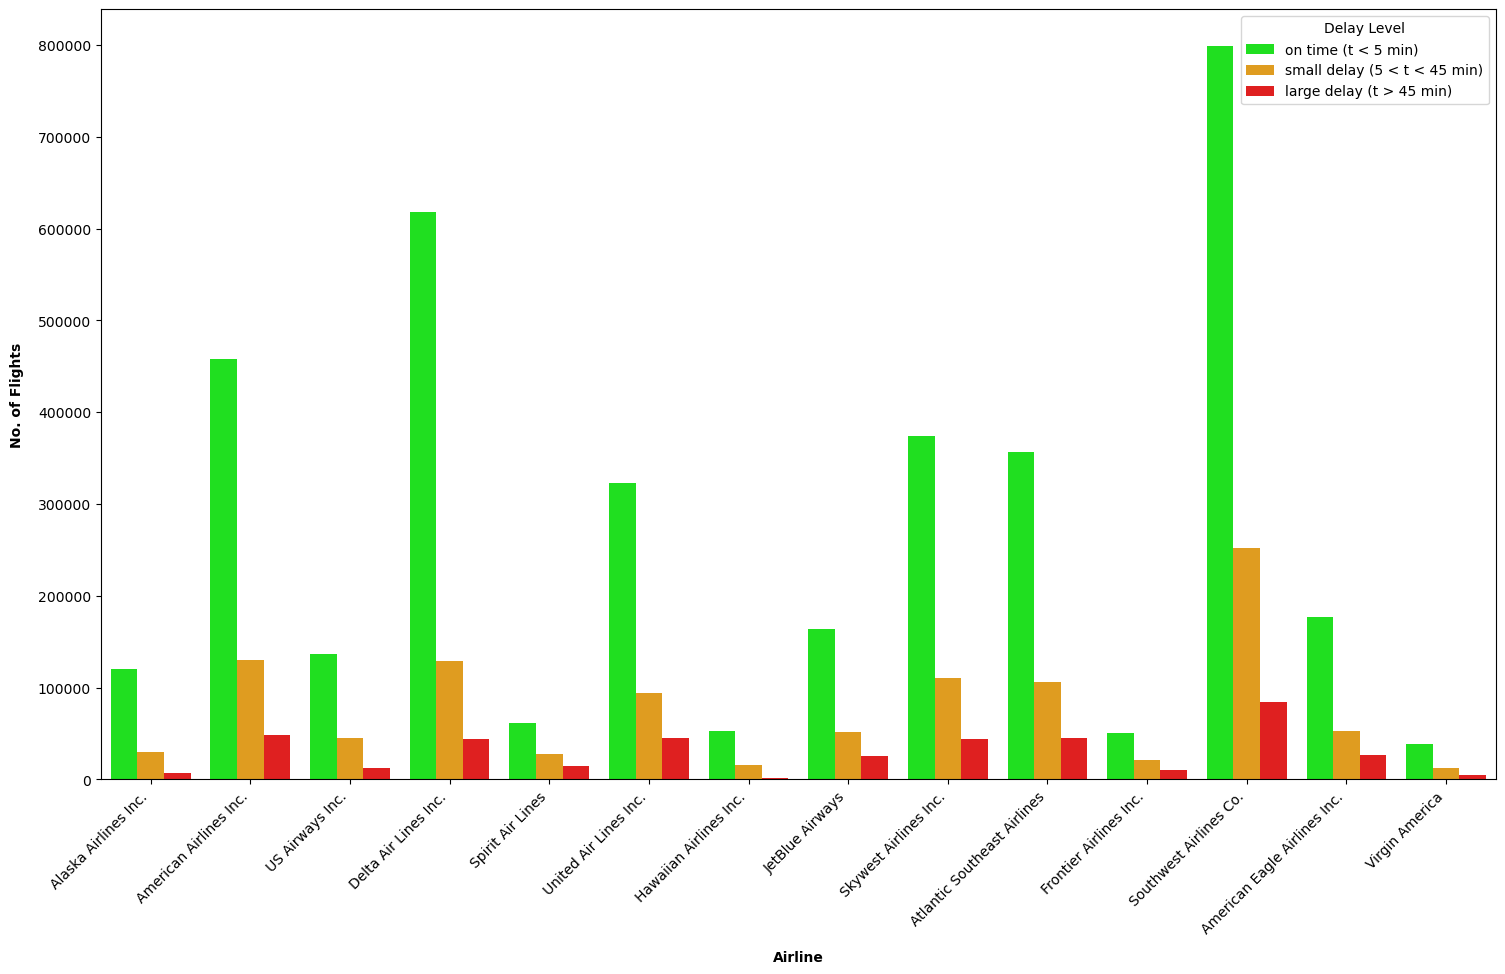

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a lambda function to classify delay types
delay_type = lambda x: 2 if x > 45 else (1 if x > 5 else 0)

# Create a copy of the Flights DataFrame to avoid modifying the original data
delayed = Flights.copy()

# Apply the delay_type function
delayed['DELAY_LEVEL'] = delayed['ARRIVAL_DELAY'].apply(delay_type)

# Create the count plot
fig = plt.figure(1, figsize=(18, 10))
ax = sns.countplot(
    x="AIRLINE_NAME",
    hue="DELAY_LEVEL",
    data=delayed,
    palette=["#00FF00", "#FFA500", "#FF0000"]
)

# Customize labels
plt.ylabel('No. of Flights', fontsize=10, weight='bold', labelpad=10)
plt.xlabel('Airline', fontsize=10, weight='bold', labelpad=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend(
    title='Delay Level',
    labels=[
        'on time (t < 5 min)', 
        'small delay (5 < t < 45 min)', 
        'large delay (t > 45 min)'
    ]
)

# Display the plot
plt.show()



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



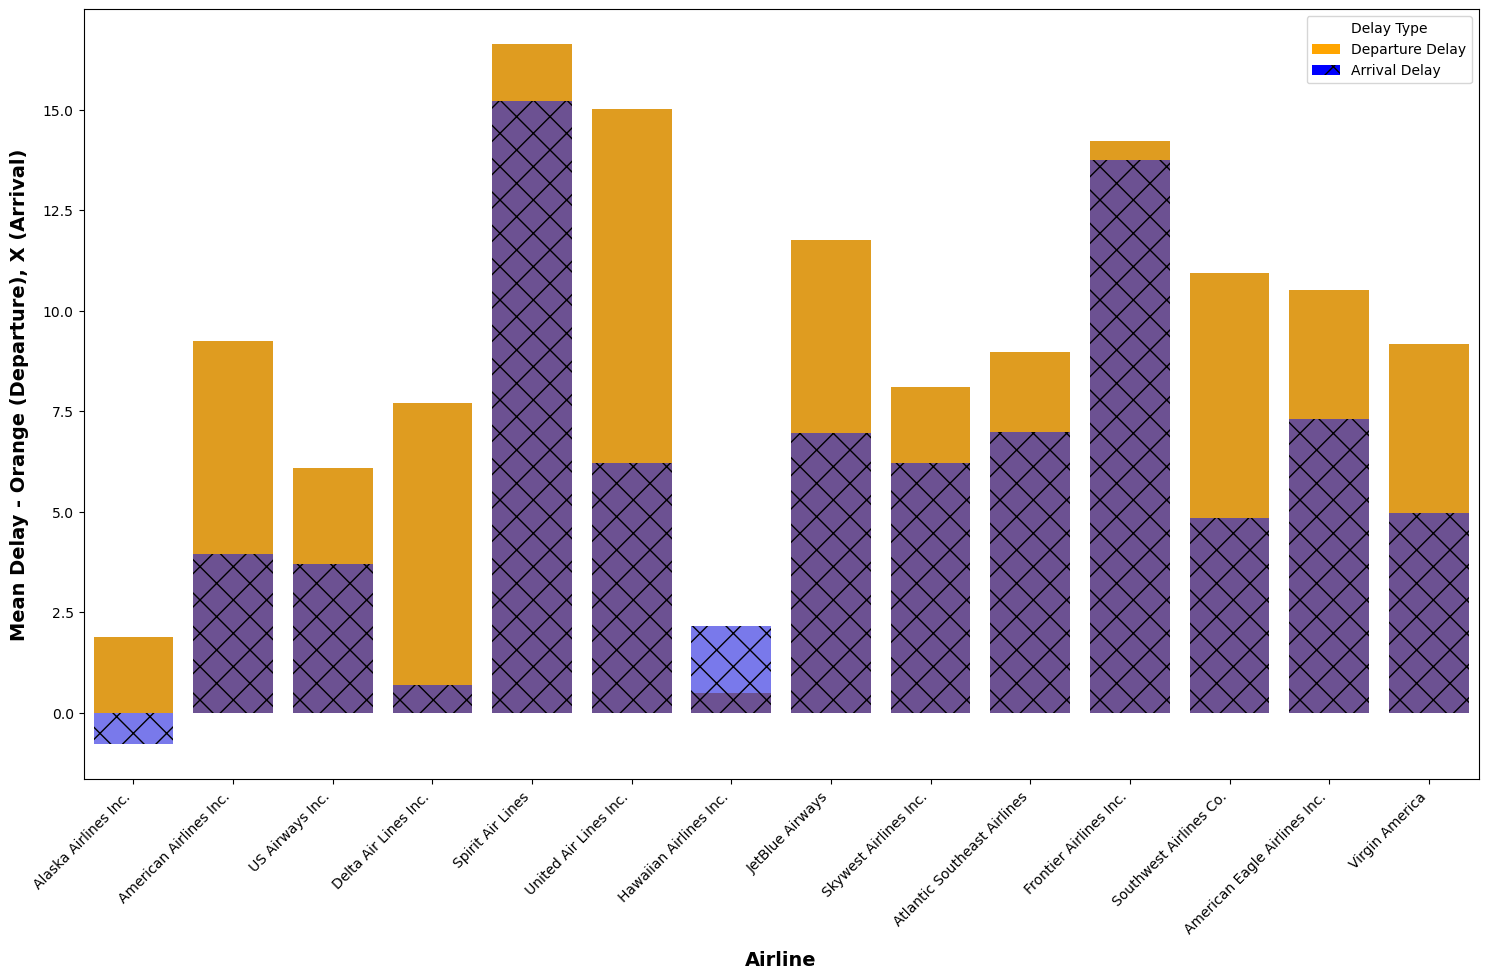

In [92]:
# Set the figure size for the bar plot
fig = plt.figure(1, figsize=(18,10))
# Plotting the departure delay (orange bars)
ax = sns.barplot(x="AIRLINE_NAME", y="DEPARTURE_DELAY", data=Flights, color="orange", ci=None)
# Overlaying the arrival delay (blue bars with 'X' hatch)
ax = sns.barplot(x="AIRLINE_NAME", y="ARRIVAL_DELAY", data=Flights, color="blue", hatch='X',
alpha=0.6, ci=None)
# Adding labels and customizing the appearance
plt.ylabel('Mean Delay - Orange (Departure), X (Arrival)',
fontsize=14, weight='bold', labelpad=10)
plt.xlabel('Airline', fontsize=14, weight='bold', labelpad=10)
# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
# Adding a legend to distinguish the two barplots
from matplotlib.patches import Patch
legend_labels = [Patch(facecolor='orange', label='Departure Delay'),
Patch(facecolor='blue', hatch='X', label='Arrival Delay')]
plt.legend(handles=legend_labels, title='Delay Type', loc='upper right')

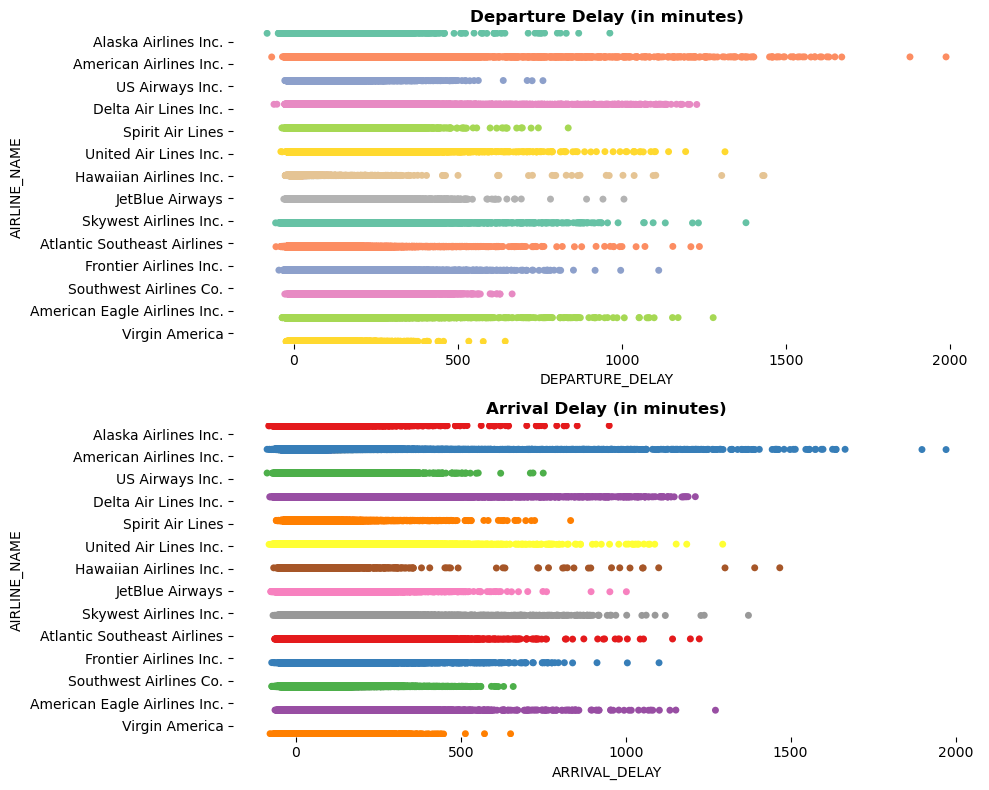

In [93]:
# Create a figure with two subplots (one for departure delays and one for arrival delays)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
# Remove the top and right spines for both subplots
sns.despine(bottom=True, left=True, ax=axs[0])
sns.despine(bottom=True, left=True, ax=axs[1])
# Create a strip plot for departure delays by airline (first subplot)
sns.stripplot(x="DEPARTURE_DELAY",
y="AIRLINE_NAME",
data=Flights,
dodge=True,
jitter=True,
palette="Set2",
ax=axs[0])
# Set the title for the first subplot
axs[0].set_title("Departure Delay (in minutes)",weight='bold')
# Create a strip plot for arrival delays by airline (second subplot)
sns.stripplot(x="ARRIVAL_DELAY",
y="AIRLINE_NAME",
data=Flights,
dodge=True,
jitter=True,
palette="Set1",
ax=axs[1])
# Set the title for the second subplot
axs[1].set_title("Arrival Delay (in minutes)",weight='bold')
# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plots
plt.show()

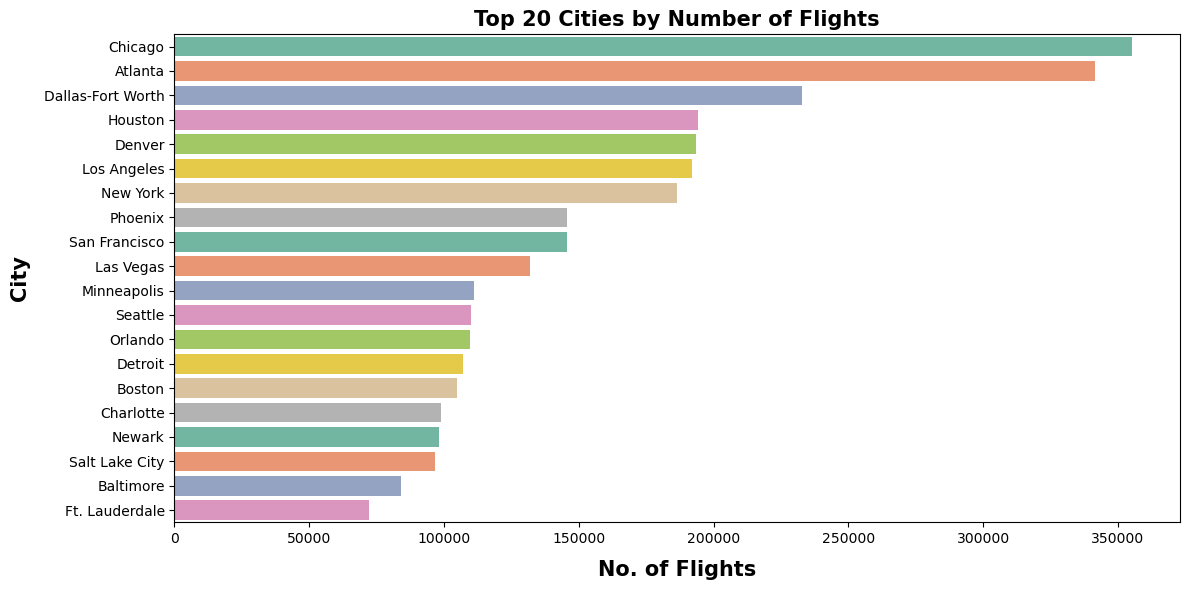

In [108]:
# Set the figure size for the bar plot
plt.figure(figsize=(12, 6))
# Create a count plot for the top 20 cities by number of flights
axis = sns.countplot(
y=Flights['ORGIN_CITY'],
data=Flights,
order=Flights['ORGIN_CITY'].value_counts().iloc[:20].index,
palette="Set2"
)
# Set the label for the x-axis (Number of Flights)
plt.xlabel('No. of Flights', fontsize=15, weight='bold', labelpad=10)
# Set the label for the y-axis (City names)
plt.ylabel('City', fontsize=15, weight='bold', labelpad=10)
# Set the title for the plot
plt.title('Top 20 Cities by Number of Flights', fontsize=15, weight='bold')
# Adjust the layout to ensure everything fits without overlapping
plt.tight_layout()
# Display # Display the plot
plt.show()

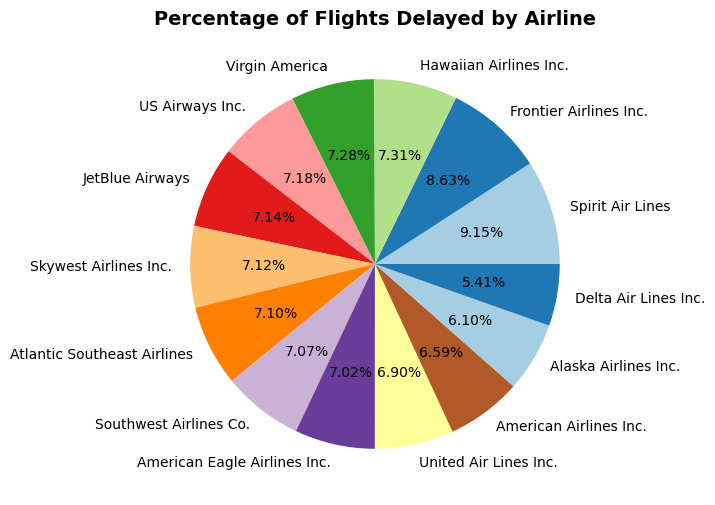

In [96]:
# Create a copy of the Flights DataFrame to avoid modifying the original data
Delayed = Flights.copy()
# Convert the 'ARRIVAL_DELAY' column to binary values: 1 if delayed, 0 if on-time or early
Delayed['ARRIVAL_DELAY'] = Delayed['ARRIVAL_DELAY'].apply(lambda x: 1 if x > 0 else 0)
# Calculate total flights and delayed flights for each airline
total_flights = Delayed.groupby('AIRLINE_NAME').size()
delayed_flights = Delayed.groupby('AIRLINE_NAME')['ARRIVAL_DELAY'].sum()
# Calculate the delay percentage
delay_percentage = (delayed_flights / total_flights) * 100
# Ensure the percentage is in the range of 1 to 100
delay_percentage = delay_percentage.clip(lower=1, upper=100)
# Sort by highest percentage of delays
delay_percentage = delay_percentage.sort_values(ascending=False)
# Plotting
plt.figure(figsize=(12,6))
# Create a pie chart
plt.pie(delay_percentage, labels=delay_percentage.index, autopct='%1.2f%%', colors=plt.cm.Paired.colors)
# Set the title of the chart
plt.title('Percentage of Flights Delayed by Airline',fontsize=14, weight='bold')
# Display the
plt.show()


The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



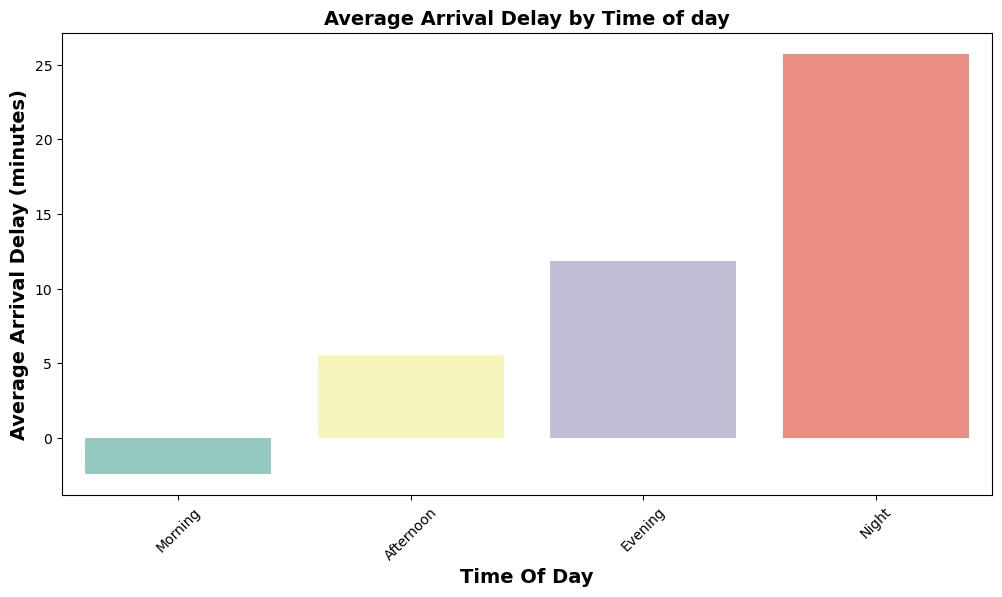

In [97]:
# Set the figure size for the bar plot
plt.figure(figsize=(12, 6))
# Create a bar plot to show the average arrival delay for each day of the time of day
sns.barplot(
x='TIME_OF_DAY',
y='ARRIVAL_DELAY',
data=Flights, order=['Morning', 'Afternoon', 'Evening', 'Night'],
palette="Set3",ci=None
)
# Set the label for the x-axis (Weekday)
plt.xlabel('Time Of Day', fontsize=14, weight='bold')
# Set the label for the y-axis (Average Arrival Delay in minutes)
plt.ylabel('Average Arrival Delay (minutes)', fontsize=14, weight='bold')
# Set the title for the plot
plt.title('Average Arrival Delay by Time of day', fontsize=14, weight='bold')
# Rotate the x-axis labels to avoid overlap and make them easier to read
plt.xticks(rotation=45)
# Display the bar plot
plt.show()


The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



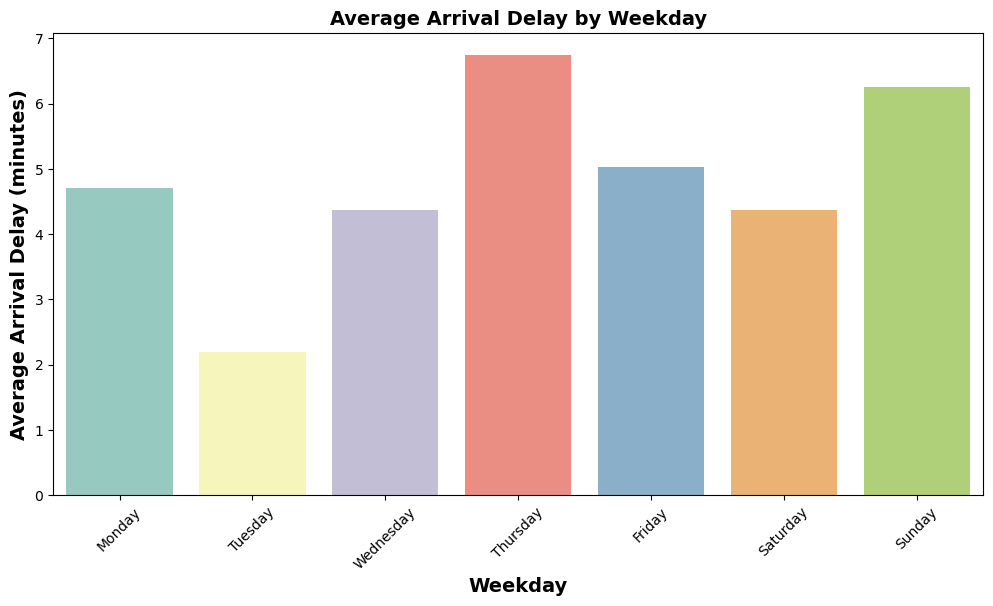

In [98]:
# Set the figure size for the bar plot
plt.figure(figsize=(12, 6))
# Create a bar plot to show the average arrival delay for each day of the week
sns.barplot(
x='WEEK',
y='ARRIVAL_DELAY',
data=Flights,order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
palette="Set3",ci=None
)
# Set the label for the x-axis (Weekday)
plt.xlabel('Weekday', fontsize=14, weight='bold')
# Set the label for the y-axis (Average Arrival Delay in minutes)
plt.ylabel('Average Arrival Delay (minutes)', fontsize=14, weight='bold')
# Set the title for the plot
plt.title('Average Arrival Delay by Weekday', fontsize=14, weight='bold')
# Rotate the x-axis labels to avoid overlap and make them easier to read
plt.xticks(rotation=45)
# Display the bar plot
plt.show()

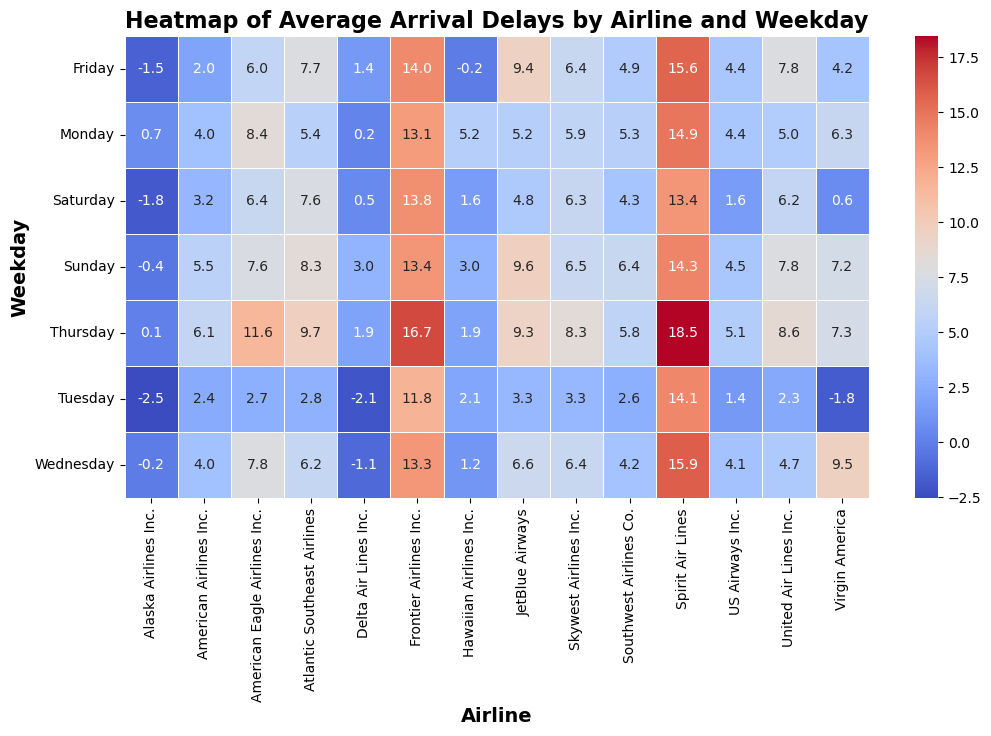

In [99]:
# Create a pivot table with Weekdays as rows, Airlines as columns, and mean arrival delay as values
pivot_table = Flights.pivot_table(index='WEEK', columns='AIRLINE_NAME', values='ARRIVAL_DELAY', aggfunc='mean')
# Set the figure size
plt.figure(figsize=(12,6))
# Plot the heatmap
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)
# Set the title and labels
plt.title('Heatmap of Average Arrival Delays by Airline and Weekday', fontsize=16,weight='bold')
plt.xlabel('Airline', fontsize=14,weight='bold')
plt.ylabel('Weekday', fontsize=14,weight='bold')
# Show the plot
plt.show()

In [123]:
import joblib
joblib.dump(label_encoders, 'label_encoder_complete.joblib')

['/Users/nandhinivijayakumar/Desktop/Project/label_encoder_complete.joblib']